# Deposited particle size measurement
1. ori_img: Target image
1. pro_img: Low-pass filtered image
1. subt_img: Subtracted image (filtered image - reference image (1st img, only electrode))
1. Threshold the subtract image with otsu value
1. Label the threshold image with original image
1. Make the labeled particles and track the **area**

# Environment

In [16]:
# Core libraries
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Image IO
import cv2
#! pip install ncempy #Install ncempy for loading *.ser file
import ncempy.io as nio

# Image process
from skimage.filters import gaussian, threshold_multiotsu
from skimage.segmentation import watershed
from skimage.color import label2rgb
from skimage.measure import label, regionprops
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

# Processing
from tqdm import tqdm #Tracking the iterations

## Define functions

### Basic functions

* print_img_shape(img):
* plot_series_imgs(imgs, process_on=False, cmap='gray', figsize=(10,10), vmax=None, vmin=None): 
* init_threshold (img):
* check_threshold(img, thres=4):
* rotate_img (img, angle):
* norm_img(img, min=0, max=1):
* plot_4_imgs(img1, img2, img3, img4, titles=["","","",""], cmap='gray'):
* def scale_bar(ax, img, scale, scale_num=2):


In [39]:
def print_img_shape(img):
  # Run initial state

  # required libraries: matplotlib

  # check it is single image or image series
    dim=img.ndim

  # for image series
    if dim>2:
      img_num, img_x, img_y = img.shape
      print("Image size: "+str(img_x)+' * '+str(img_y))
      print("Number of images: "+str(img_num))
      show_img=img[0]


  # for single image
    else: 
      img_num = 1
      img_x, img_y = img.shape
      print("Image size: "+str(img_x)+' * '+str(img_y))
      show_img=img

  # plot basic image and its histogram
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    ax[0].imshow(show_img, cmap='gray')
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].hist(show_img.ravel(), bins=255)
    ax[1].set_title('Histogram')
    ax[1].set_xlabel('Pixel intensity')
    ax[1].set_ylabel('Pixel counts')

    plt.subplots_adjust()

    plt.show()

    
  #Return image width and height
    return img_num, img_x, img_y

def plot_series_imgs(imgs, process_on=False, cmap='gray', figsize=(10,10), vmax=None, vmin=None): 
    # Plot the images as gray scale
    # required libraries: matplotlib, numpy

    # Check it is single image (dim=2) or image series (dim>2)
    dim=imgs.ndim

    plt.figure(figsize=figsize)

    # for image series
    if dim>2: 
      img_num, img_x, img_y = imgs.shape
      
    # Maximum number of images = 36 (6*6)
      if img_num>36:
        draw_num=36
      else:
        draw_num=img_num
      num_ratio=(img_num/draw_num) # >=1

    # Find proper row and column
      row=6
      for i in range(6):
        if i*i>=img_num:
          row=i
          break

    #Plot images on figure with selected row and column
      img_list=[]

      for i in range(draw_num):
        plt.subplot(row, row, i+1)
        cur_img=int(i*num_ratio)
        img_list.append(cur_img)
        if process_on:
          plt.imshow(img_process(imgs[cur_img]), cmap=cmap, vmax=vmax, vmin=vmin)
        else:
          plt.imshow(imgs[cur_img], cmap=cmap, vmax=vmax, vmin=vmin)
        plt.axis('off')
        
      plt.subplots_adjust(wspace=0)

      for j in range(row):
        print(img_list[row*j:row*(j+1)])

    # for single image
    else:
      img_x, img_y = imgs.shape
      if process_on: # for plotting with image process
        plt.imshow(img_process(imgs), cmap=cmap, vmax=vmax, vmin=vmin)  
      else:
        plt.imshow(imgs, cmap=cmap, vmax=vmax, vmin=vmin)  
      plt.axis('off')

    if not cmap == 'gray':
      cax = plt.axes([0.9, 0.1, 0.05, 0.8])
      plt.colorbar(cax=cax)
  


def init_threshold (img):
  #show multiple thresholdings
  
    max_int=np.max(img)
    min_int=np.min(img)

    fig = plt.figure(figsize=(10,10))
    for i in range(9):
      ax=fig.add_subplot(330+i+1)
      ax.imshow(img>(max_int-min_int)/9*i+min_int, cmap='gray')
      ax.axis('off')
    fig.tight_layout()

    print("Intensity range: "+str(min_int) + ' ~ ' + str(max_int))

def check_threshold(img, thres=4):
  #continue with init_threshold
  #choose one of threshold from init_threshold
  #print and plot selected threshold

    max_int=np.max(img)
    min_int=np.min(img)

    fig = plt.figure(figsize=(10,10))
    ax=fig.add_subplot()
    ax.imshow(img>(max_int-min_int)/9*thres+min_int, cmap='gray')
    ax.axis('off')

    print((max_int-min_int)/9*thres+min_int)   

def rotate_img (img, angle):

    # dividing height and width by 2 to get the center of the image
    height, width = img.shape[:2]
    # get the center coordinates of the image to create the 2D rotation matrix
    center = (width/2, height/2)
    # using cv2.getRotationMatrix2D() to get the rotation matrix
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1) 
    # rotate the image using cv2.warpAffine
    rotated_img = cv2.warpAffine(src=img, M=rotate_matrix, dsize=(width, height))
    # crop blank area
    crop=0.03 # 3%
    h_crop=int(height*crop)
    w_crop=int(width*crop)

    return rotated_img[h_crop:height-h_crop, w_crop:width-w_crop]

def norm_img(img, min=0, max=1):
    cv2.normalize(img, img, min, max, cv2.NORM_MINMAX)
    return img


def plot_4_imgs(img1, img2, img3, img4, titles=["","","",""], cmap='gray'):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

    ax[0][0].imshow(img1, cmap=cmap)
    ax[0][0].set_title(titles[0])
    ax[0][0].axis('off')

    ax[0][1].imshow(img2, cmap=cmap)
    ax[0][1].set_title(titles[1])
    ax[0][1].axis('off')

    ax[1][0].imshow(img3, cmap=cmap)
    ax[1][0].set_title(titles[2])
    ax[1][0].axis('off')

    ax[1][1].imshow(img4, cmap=cmap)
    ax[1][1].set_title(titles[3])
    ax[1][1].axis('off')

    plt.subplots_adjust()

    plt.show()

def scale_bar(ax, img, scale, scale_num=2):
    img_w, img_h=img.shape
    scalebar=mpatches.Rectangle((img_w*0.1, img_h*0.9), (1/((scale*10**6))*scale_num), (img_h*0.02), edgecolor='None', facecolor='white', fill='True')
    ax.add_patch(scalebar)
    ax.text((img_w*0.1+0.5*(1/(scale*10**6)*scale_num)), (img_h*0.9-img_h*0.05), str(scale_num)+' um', horizontalalignment='center', fontsize=15, color='white')

### User functions
* def img_process(ori_img, ref_img):
* def mask_img(ori_img) :
* def watershed_process(image):

In [18]:
def img_process(ori_img, ref_img):  #, threshold=1):
    
    #Basic function
    #pro_img = ori_img

    # Crop: Square, 600 px
    pro_img=ori_img[350:950,600:1200]
    ref_img=ref_img[350:950,600:1200]

    # Rotate: 4 degree, 594 px (small crop due to rotation)
    pro_img=rotate_img(pro_img, 4)
    ref_img=rotate_img(ref_img, 4)

    # Mask: Select only TiNx electrode area
    pro_img=mask_img(pro_img)
    ref_img=mask_img(ref_img)

    # Subtraction
    pro_img = pro_img-ref_img

    return pro_img

def mask_img(ori_img) :
    ori_img=norm_img(ori_img, 0, 255)
    rows, cols = ori_img.shape
    mask = np.zeros((rows, cols), np.uint8)
    r_out = 340 # outer boundary
    r_in = 125 # inner boundary
    center = [300, 400] # Y, X center
    x, y = np.ogrid[:rows, :cols]
    mask_area = np.logical_and(((x - center[0]) ** 2 + (y - center[1]) ** 2 >= r_in ** 2),
                                ((x - center[0]) ** 2 + (y - center[1]) ** 2 <= r_out ** 2))
    mask[mask_area] = 1
    mask[:, 530:] = 0
    #ori_img=norm_img(ori_img)
    masked_img=ori_img*mask

    reverse_mask = np.ones((rows, cols), np.uint8) - mask
    masked_img=masked_img+reverse_mask*255

    return masked_img  

def watershed_process(image):
    distance = ndi.distance_transform_edt(image)
    coords = peak_local_max(distance, min_distance=15, footprint=np.ones((3, 3)), labels=image)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    label_img = watershed(-distance, markers, mask=image)
    return label_img

# Cu plating and stripping

## Load data

In [19]:
img_file='data\CCD Preview2_1.ser'

imgs=nio.read(img_file) # load file
img_num, img_x, img_y = imgs['data'].shape
print('Number of images: ' + str(img_num))
print('Size of image: ' + str(img_x) + ' x ' + str(img_y))

scale=imgs['pixelSize'][0]
print('1 pixel: '+str(scale) + ' ' +imgs['pixelUnit'][0])

Number of images: 600
Size of image: 1024 x 1376
1 pixel: 1.1961722488039111e-08 m


Image size: 1024 * 1376
Number of images: 600


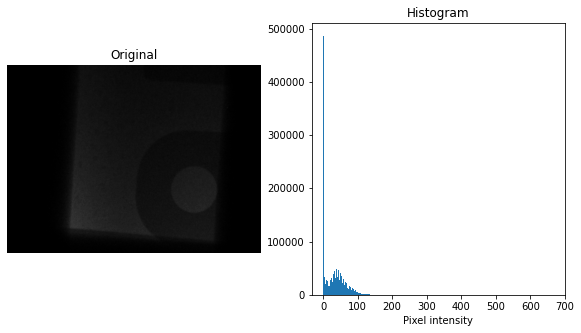

In [20]:
img_num, img_x, img_y = print_img_shape(imgs['data'])

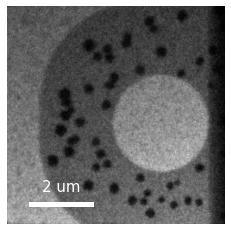

In [42]:
#total 600 / 8 = 75 frames
#Blank(0:74), P1(75:149), S1(150:224), P2(225:299), 
#S2(300:374), P3(375:449), S3(450:524), P4(525:599)

# 1 original, 2 crop, 3 rotate, 4 gaussian, 
# 5 mask, 6 subtraction, 7 threshold, 8 segmentation

cur_num=149
img_name='img_149_10_scale'
fname='results/'+img_name+'.png'

ori_img=imgs['data'][cur_num]

pro_img=ori_img

pro_img=pro_img[350:950,600:1200]

pro_img=rotate_img(pro_img,4)

# pro_img=gaussian(pro_img, 3)

# pro_img=mask_img(pro_img)

# ref_img=mask_img(gaussian(rotate_img(imgs['data'][74][350:950,600:1200],4),3))

# pro_img=pro_img-ref_img

# pro_img=pro_img<-38

#pro_img = watershed_process(pro_img)

fig, ax = plt.subplots()

ax.imshow(pro_img,cmap='gray')
#ax.imshow(pro_img, cmap=plt.cm.nipy_spectral)

scale_bar(ax, pro_img, scale, 2)

ax.axis('off')

# for region in regionprops(pro_img):
#     minr, minc, maxr, maxc = region.bbox
#     rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
#                               fill=False, edgecolor='red', linewidth=1)
#     ax.add_patch(rect)


plt.savefig(fname, bbox_inches='tight', pad_inches=0.0)


## Basic image process

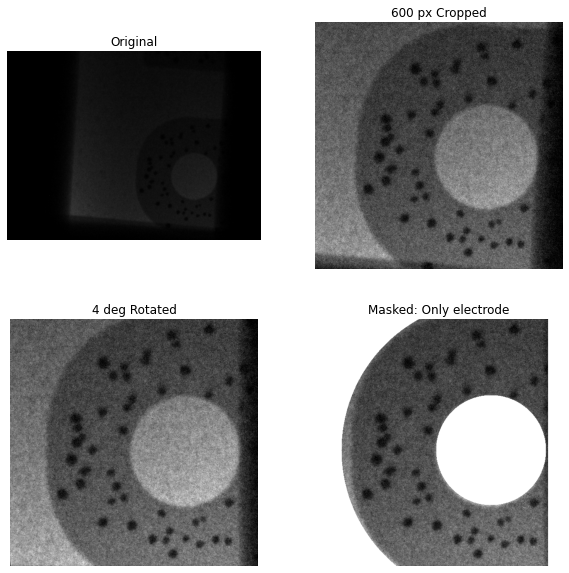

In [10]:
# Crop, Rotate and Mask
titles=["","","",""]

cur_num=100
ori_img=imgs['data'][cur_num]
titles[0]=('Original')

# Crop: Square, 600 px
crop_img=ori_img[350:950,600:1200]
titles[1]=('600 px Cropped')

# Rotate: 4 degree, 594 px (small crop due to rotation)
rot_img=rotate_img(crop_img, 4)
titles[2]=('4 deg Rotated')

# Mask: Select only TiNx electrode area
masked_img=mask_img(rot_img)
titles[3]=('Masked: Only electrode')

plot_4_imgs(ori_img, crop_img, rot_img, masked_img, titles)


Threshold candidates: [-38.05559269  -8.64590114]


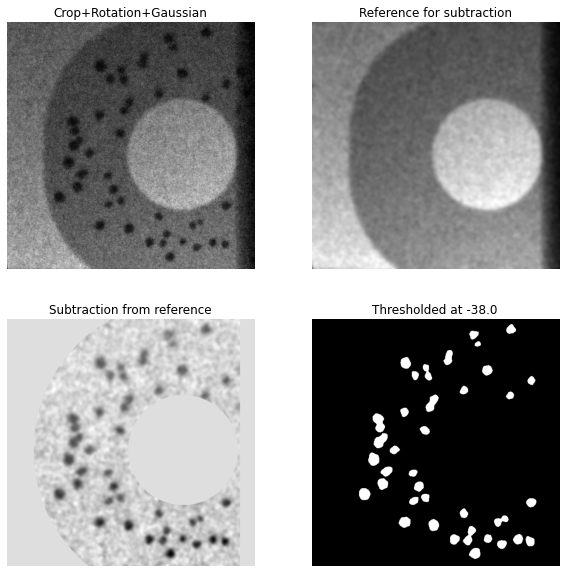

In [13]:
# Gaussian, Subtraction from reference, threshold
titles=["","","",""]

# Crop+Rotation+Gaussian: Square
cur_num=100#149
crop_img=rotate_img(imgs['data'][cur_num][350:950,600:1200], 4)
gaus_img=gaussian(crop_img, 3)
titles[0]=('Crop+Rotation+Gaussian')

# Reference: electrode without plating
ref_num=74
ref_img=gaussian(rotate_img(imgs['data'][ref_num][350:950,600:1200], 4),3)
titles[1]=('Reference for subtraction')

# Subtraction after masking
masked_subt_img=mask_img(gaus_img)-mask_img(ref_img)
titles[2]=('Subtraction from reference')

# Threshold image
thres=threshold_multiotsu(masked_subt_img)
print('Threshold candidates: '+ str(thres))
threshold_img=masked_subt_img<np.round(thres[0])
titles[3]=('Thresholded at '+str(np.round(thres[0])))

plot_4_imgs(crop_img, ref_img, masked_subt_img, threshold_img, titles)


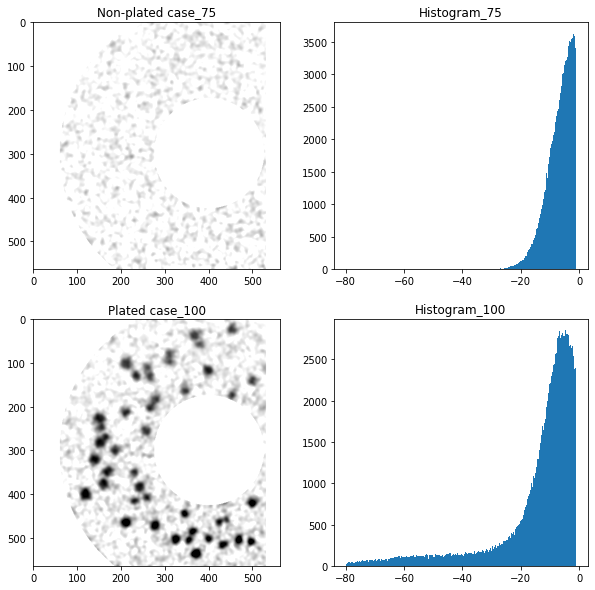

In [14]:
# Comparing the threshold effect between non-plated and plated

vmin=-80
vmax=-1

cur_num=75
ref_num=70

ori_img=rotate_img(imgs['data'][cur_num][350:950,600:1200], 4)
ori_img=gaussian(ori_img,3)
ref_img=(gaussian(rotate_img(imgs['data'][ref_num][350:950,600:1200], 4), 3))

pro_img=mask_img(ori_img)-mask_img(ref_img)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0][0].imshow(pro_img, cmap='gray', vmin=vmin, vmax=vmax)
ax[0][0].set_title('Non-plated case_'+str(cur_num))

ax[0][1].hist(pro_img.ravel(), bins=255, range=[-80, -1])
ax[0][1].set_title('Histogram_'+str(cur_num))

cur_num=100
ref_num=70

ori_img=rotate_img(imgs['data'][cur_num][350:950,600:1200], 4)
ori_img=gaussian(ori_img,3)
ref_img=(gaussian(rotate_img(imgs['data'][ref_num][350:950,600:1200], 4), 3))

pro_img=mask_img(ori_img)-mask_img(ref_img)

ax[1][0].imshow(pro_img, cmap='gray', vmin=vmin, vmax=vmax)
ax[1][0].set_title('Plated case_'+str(cur_num))

ax[1][1].hist(pro_img.ravel(), bins=255, range=[-80, -1])
ax[1][1].set_title('Histogram_'+str(cur_num))

plt.show()

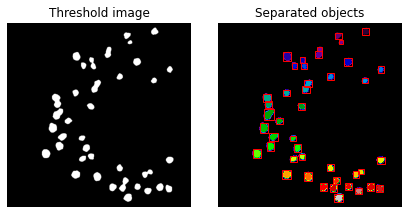

In [15]:
label_img = watershed_process(threshold_img)

fig, axes = plt.subplots(ncols=2, figsize=(6, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(threshold_img, cmap=plt.cm.gray)
ax[0].set_title('Threshold image')
ax[1].imshow(label_img, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Separated objects')

for region in regionprops(label_img):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)
    ax[1].add_patch(rect)

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

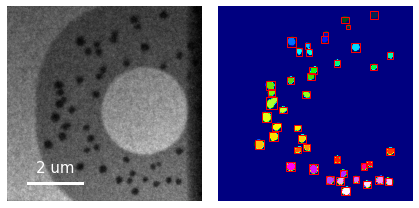

In [43]:
label_img = watershed_process(threshold_img)

fig, axes = plt.subplots(ncols=2, figsize=(6, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(crop_img, cmap=plt.cm.gray)
#ax[0].set_title('Threshold image')

scale_bar(ax[0], crop_img, scale, 2)

ax[1].imshow(label_img, cmap='gist_ncar')#plt.cm.nipy_spectral)
#ax[1].set_title('Separated objects')

for region in regionprops(label_img):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)
    ax[1].add_patch(rect)

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()


#plt.imshow(markers, cmap='gray',vmin=0, vmax=1)

In [ ]:
# # Particle detection

# fig=plt.figure(figsize=(3,6))
# fig.set_dpi(300)
# ax1=fig.add_subplot(1,2,1)
# ax1.imshow(threshold_img, cmap='gray')
# ax1.set_title('Threshold')
# ax1.axis('off')

# ax6=fig.add_subplot(1,2,2)

# # # particle detection by label
# # from skimage.measure import label, regionprops
# # import matplotlib.patches as mpatches
# # image=masked_img #original image
# # label_img = label(threshold_img) 

# ax6.imshow(rot_img, cmap='gray')
# ax6.set_title('Detection')
# ax6.axis('off')

# i=0
# for region in regionprops(label_img):
#     minr, minc, maxr, maxc = region.bbox
#     rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
#                               fill=False, edgecolor='red', linewidth=1)
#     ax6.add_patch(rect)
#     i=i+1
# print(i)

## Data extraction (ex. area, number)

In [46]:
# Data extraction from single image
particles_df=pd.DataFrame(columns=['y_min', 'x_min', 'y_max', 'x_max'])
particles_df[str(cur_num)]=0

i=0
cur_particles=regionprops(label_img, gaus_img)
for particle in cur_particles:
    cur_y_min, cur_x_min, cur_y_max, cur_x_max = particle.bbox
    cur_y, cur_x= particle.centroid
    cur_area=(particle.area*(scale*10**6)**2) #[um2]
    if cur_area<0.01:
        continue
    particle=-1 # -1: not in table
    cur_df = pd.DataFrame(
        {
            "y_min": [cur_y_min],
            "x_min": [cur_x_min],
            "y_max": [cur_y_max],
            "x_max": [cur_x_max],
            str(cur_num): [cur_area],
        },
    )

    if len(particles_df)==0:
            particles_df.loc[len(particles_df), :]=0
            particles_df.loc[len(particles_df)-1, ['y_min','x_min','y_max','x_max', str(cur_num)]] = cur_df.loc[0, ['y_min','x_min','y_max','x_max',str(cur_num)]]                
            continue
    
    for row in range(len(particles_df)):
        box_pos=particles_df.iloc[[row],[0,1,2,3]].values.tolist()[0]
        if box_pos[0]<cur_y and cur_y<box_pos[2] and box_pos[1]<cur_x and cur_x<box_pos[3]:
            particle=row
            break
    
    if particle==-1:
        particles_df.loc[len(particles_df), :]=0
        particles_df.loc[len(particles_df)-1, ['y_min','x_min','y_max','x_max', str(cur_num)]] = cur_df.loc[0, ['y_min','x_min','y_max','x_max',str(cur_num)]]
    else:
        particles_df.loc[row, ['y_min','x_min','y_max','x_max',str(cur_num)]] = cur_df.loc[0, ['y_min','x_min','y_max','x_max',str(cur_num)]]

    i+=1

print(len(particles_df))
particles_df.head()


14


,y_min,x_min,y_max,x_max,599
0,49.0,513.0,81.0,530.0,0.064673
1,100.0,454.0,133.0,486.0,0.097439
2,118.0,461.0,164.0,503.0,0.162685
3,133.0,482.0,178.0,524.0,0.165547
4,150.0,220.0,202.0,280.0,0.345116


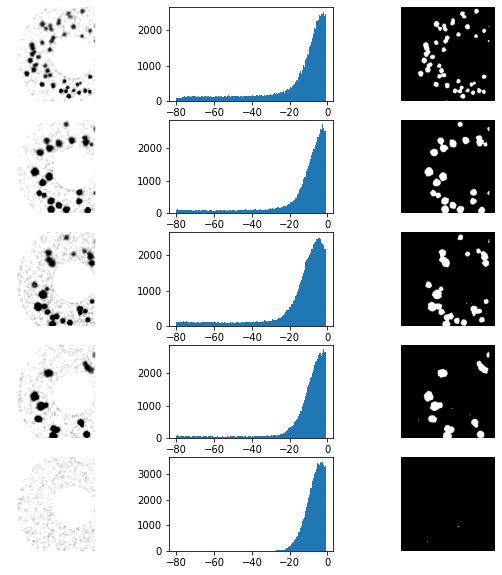

In [ ]:
# Comparing the threshold effect between non-plated and plated

#total 600 / 8 = 75 frames
#Blank(0:74), P1(75:149), S1(150:224), P2(225:299), 
#S2(300:374), P3(375:449), S3(450:524), P4(525:599)

vmin=-80
vmax=-1

cur_num=149
ref_num=74

fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(10, 10))



for i in range(4):
  ori_img=rotate_img(imgs['data'][cur_num][350:950,600:1200], 4)
  ori_img=gaussian(ori_img,3)
  ref_img=(gaussian(rotate_img(imgs['data'][ref_num][350:950,600:1200], 4), 3))
  pro_img=mask_img(ori_img)-mask_img(ref_img)

  ax[i][0].imshow(pro_img, cmap='gray', vmin=vmin, vmax=vmax)
  #ax[i][0].set_title('Mask_Subtraction_'+str(cur_num))
  ax[i][0].axis('off')

  ax[i][1].hist(pro_img.ravel(), bins=255, range=[-80, -1])
  #ax[i][1].set_title('Histogram_'+str(cur_num))
  #ax[i][1].axis('off')

  ax[i][2].imshow(pro_img<-30,cmap='gray')
  #ax[i][2].set_title('Threshold(-30)_'+str(cur_num))
  ax[i][2].axis('off')

  cur_num=cur_num+150
  ref_num=ref_num+150

#non plated
cur_num=75
ref_num=74
ori_img=rotate_img(imgs['data'][cur_num][350:950,600:1200], 4)
ori_img=gaussian(ori_img,3)
ref_img=(gaussian(rotate_img(imgs['data'][ref_num][350:950,600:1200], 4), 3))
pro_img=mask_img(ori_img)-mask_img(ref_img)

i=4
ax[i][0].imshow(pro_img, cmap='gray', vmin=vmin, vmax=vmax)
#ax[i][0].set_title('Mask_Subtraction_'+str(cur_num))
ax[i][0].axis('off')

ax[i][1].hist(pro_img.ravel(), bins=255, range=[-80, -1])
#ax[i][1].set_title('Histogram_'+str(cur_num))
#ax[i][1].axis('off')

ax[i][2].imshow(pro_img<-30,cmap='gray')
#ax[i][2].set_title('Threshold(-30)_'+str(cur_num))
ax[i][2].axis('off')

plt.show()

In [45]:
# Data extraction from image series

#total 600 / 8 = 75 frames
#Blank(0:74), P1(75:149), S1(150:224), P2(225:299), 
#S2(300:374), P3(375:449), S3(450:524), P4(525:599)

thres_cut=-30

#particles_df=pd.DataFrame(columns=['y_min', 'x_min', 'y_max', 'x_max'])

# Plating

ref_num=74
skip=1
frame=75 #number of frames
shift=75 #start frame: 75 for plating, 150 for stripping

for cycle in range(4):
    particles_df=pd.DataFrame(columns=['y_min', 'x_min', 'y_max', 'x_max'])
    phase='P'+str(cycle+1) # plating

#for cycle in range(3):
    #paritlces_df = df.iloc[0:0]
    #particles_df=pd.DataFrame(columns=['y_min', 'x_min', 'y_max', 'x_max'])
    #phase='S'+str(cycle+1) # stripping

    ref_img=gaussian(rotate_img(imgs['data'][ref_num][350:950,600:1200], 4), 3)

    print("image from ", str(shift), " to ", str((frame-1)*skip+shift))

    for i in tqdm(range(frame)):
        cur_num=i*skip+shift
        #print(cur_num)

        # Image process part
        ori_img=rotate_img(imgs['data'][cur_num][350:950,600:1200], 4)
        gaus_img=gaussian(ori_img,3)
        gaus_subt_img=mask_img(gaus_img)-mask_img(ref_img)
        threshold_img=gaus_subt_img<thres_cut
        label_img = watershed_process(threshold_img)

        # Data extraction part
        particles_df[str(cur_num)]=0
        i=0
        cur_particles=regionprops(label_img, gaus_img)
        for particle in cur_particles:
            cur_y_min, cur_x_min, cur_y_max, cur_x_max = particle.bbox
            cur_y, cur_x= particle.centroid
            #cur_area=int(particle.area)
            cur_area=particle.area*((scale*10**6)**2) #[um^2]
            if cur_area<0.01: #10
                continue
            particle=-1 # -1: not in table
            cur_df = pd.DataFrame(
                {
                    "y_min": [cur_y_min],
                    "x_min": [cur_x_min],
                    "y_max": [cur_y_max],
                    "x_max": [cur_x_max],
                    str(cur_num): [cur_area],
                },
            )

            if len(particles_df)==0:
                    particles_df.loc[len(particles_df), :]=0
                    particles_df.loc[len(particles_df)-1, ['y_min','x_min','y_max','x_max', str(cur_num)]] = cur_df.loc[0, ['y_min','x_min','y_max','x_max',str(cur_num)]]                
                    continue
            
            for row in range(len(particles_df)):
                box_pos=particles_df.iloc[[row],[0,1,2,3]].values.tolist()[0]
                if box_pos[0]<cur_y and cur_y<box_pos[2] and box_pos[1]<cur_x and cur_x<box_pos[3]:
                    particle=row
                    break
            
            if particle==-1:
                particles_df.loc[len(particles_df), :]=0
                particles_df.loc[len(particles_df)-1, ['y_min','x_min','y_max','x_max', str(cur_num)]] = cur_df.loc[0, ['y_min','x_min','y_max','x_max',str(cur_num)]]
            else:
                particles_df.loc[row, ['y_min','x_min','y_max','x_max',str(cur_num)]] = cur_df.loc[0, ['y_min','x_min','y_max','x_max',str(cur_num)]]

            i+=1

    particles_df.to_csv('results/'+phase+'.csv')

    ref_num=ref_num+150
    shift=shift+150


image from  75  to  149


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:35<00:00,  2.10it/s]


image from  225  to  299


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:16<00:00,  4.48it/s]


image from  375  to  449


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:19<00:00,  3.79it/s]


image from  525  to  599


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:12<00:00,  5.83it/s]


## Draw graphs from dataframe (or csv)

In [ ]:
#csv_file='/content/drive/MyDrive/data/TiNx_Hongyu/Data/CA_T_I_V.csv'

csv_df=pd.read_csv('/content/drive/MyDrive/data/TiNx_Hongyu/Result/P1.csv', index_col=1)

csv_file='/content/drive/MyDrive/data/TiNx_Hongyu/Result/P2.csv'
csv_df_1=pd.read_csv(csv_file, index_col=1)

(0.0, 0.25)

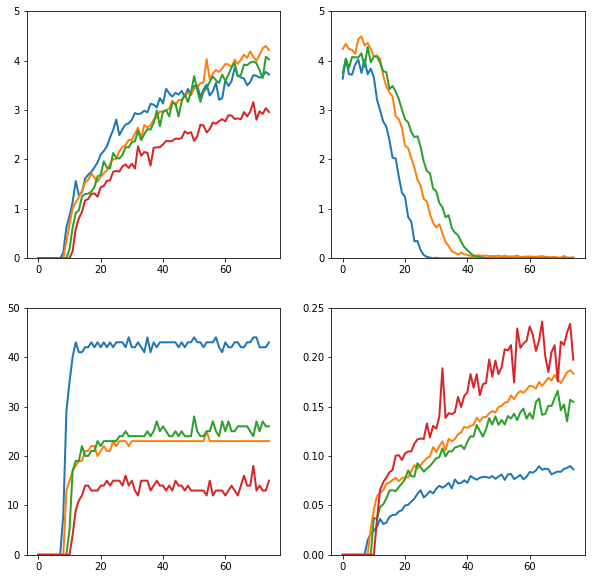

In [47]:
# Number of particles
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

#ax[0][0].set_title('Total area [um^2] of particles')
#ax[0][1].set_title('Total area [um^2] of particles')
#ax[1][0].set_title('Number of particles')
#ax[1][1].set_title('Average area [um^2] of particles')
# ax[1][1].set_title('Average diameter [um] of particles')


for i in range(4):
    csv_df=pd.read_csv('results/P'+str(i+1)+'.csv', index_col=1)

    label='P'+str(i+1)
    # Total plated area 
    csv_df.mask(csv_df == 0.0).iloc[:, 4:].sum().plot(ax=ax[0][0], label=label, lw=2)
    # Number of particles
    (csv_df.mask(csv_df == 0.0).iloc[:, 4:]>0.0).sum().plot(ax=ax[1][0], label=label, lw=2)
    # Average area of particles
    #csv_df.iloc[:, 4:].mean().plot(ax=ax[1][0], label=label)
    csv_df.mask(csv_df == 0.0).iloc[:, 4:].mean().fillna(0).plot(ax=ax[1][1], label=label, lw=2)
    # # Average area of particles
    # csv_df.mask(csv_df == 0.0).iloc[:, 4:].divide(np.pi).apply(np.sqrt).mul(2).mean().plot(ax=ax[1][1], label=label)

for i in range(3):
    csv_df=pd.read_csv('results/S'+str(i+1)+'.csv', index_col=1)

    label='S'+str(i+1)
    # Total plated area 
    csv_df.iloc[:, 4:].sum().plot(ax=ax[0][1], label=label, lw=2)

#ax[0][0].legend()
#ax[0][1].legend()
#ax[1][0].legend()
#ax[1][1].legend()

labels = [item.get_text() for item in ax[0][0].get_xticklabels()]
labels[1] = '0'
labels[2] = '20'
labels[3] = '40'
labels[4] = '60'
labels[5] = '80'
ax[0][0].set_xticklabels(labels)
ax[0][1].set_xticklabels(labels)
ax[1][0].set_xticklabels(labels)
ax[1][1].set_xticklabels(labels)
ax[0][0].set_ylim(0,5)
ax[0][1].set_ylim(0,5)
ax[1][0].set_ylim(0,50)
ax[1][1].set_ylim(0,0.25)

In [48]:
total_plated_area_df=pd.DataFrame({'frame':range(75)})
particle_number_df=pd.DataFrame({'frame':range(75)})
average_plated_area_df=pd.DataFrame({'frame':range(75)})
total_stripped_area_df=pd.DataFrame({'frame':range(75)})

for i in range(4):
    csv_df=pd.read_csv('results/P'+str(i+1)+'.csv', index_col=1)
    temp_df=csv_df.mask(csv_df == 0.0).iloc[:, 4:].sum().to_frame().reset_index().drop(columns=['index'])
    temp_df.columns=['P'+str(i+1)]
    total_plated_area_df=total_plated_area_df.join(temp_df)

    temp_df=(csv_df.mask(csv_df == 0.0).iloc[:, 4:]>0.0).sum().to_frame().reset_index().drop(columns=['index'])
    temp_df.columns=['P'+str(i+1)]
    particle_number_df=particle_number_df.join(temp_df)

    temp_df=csv_df.mask(csv_df == 0.0).iloc[:, 4:].mean().fillna(0).to_frame().reset_index().drop(columns=['index'])
    temp_df.columns=['P'+str(i+1)]
    average_plated_area_df=average_plated_area_df.join(temp_df)

for i in range(3):
    csv_df=pd.read_csv('results/S'+str(i+1)+'.csv', index_col=1)
    temp_df=csv_df.mask(csv_df == 0.0).iloc[:, 4:].sum().to_frame().reset_index().drop(columns=['index'])
    temp_df.columns=['S'+str(i+1)]
    total_stripped_area_df=total_stripped_area_df.join(temp_df)

total_plated_area_df.to_csv('results/total_plated_area.csv', index=False)
particle_number_df.to_csv('results/particle_number.csv', index=False)
average_plated_area_df.to_csv('results/average_plated_area.csv', index=False)
total_stripped_area_df.to_csv('results/total_stripped_area.csv', index=False)

# Make animation

## extract data for graph

In [3]:
img_file='data\CCD Preview2_1.ser'
imgs=nio.read(img_file) # load file
img_num, img_x, img_y = imgs['data'].shape
print('Number of images: ' + str(img_num))
print('Size of image: ' + str(img_x) + ' x ' + str(img_y))

scale=imgs['pixelSize'][0]
print('1 pixel: '+str(scale) + ' ' +imgs['pixelUnit'][0])

Number of images: 600
Size of image: 1024 x 1376
1 pixel: 1.1961722488039111e-08 m


In [ ]:
# Data extraction from image series

#total 600 / 8 = 75 frames
#Blank(0:74), P1(75:149), S1(150:224), P2(225:299), 
#S2(300:374), P3(375:449), S3(450:524), P4(525:599)

thres_cut=-30

particles_df=pd.DataFrame(columns=[str(-1)])

ref_num=74
frame=75 #number of frames
shift=75 #start frame

for cycle in range(7):
    ref_img=gaussian(rotate_img(imgs['data'][ref_num+150*(cycle%2)][350:950,600:1200], 4), 3)

    for i in tqdm(range(frame)):
        cur_num=i+shift*(cycle+1)

        # Image process part
        ori_img=rotate_img(imgs['data'][cur_num][350:950,600:1200], 4)
        gaus_img=gaussian(ori_img,3)
        gaus_subt_img=mask_img(gaus_img)-mask_img(ref_img)
        threshold_img=gaus_subt_img<thres_cut
        label_img = watershed_process(threshold_img)

        # Data extraction part
        cur_df=pd.DataFrame(columns=[str(cur_num)])
        #particles_df[str(cur_num)]=0
        cur_particles=regionprops(label_img, gaus_img)
        for particle in cur_particles:
            cur_area=particle.area*((scale*10**6)**2) #[um^2]
            if cur_area<0.01: #10
                continue
            cur_df.loc[len(cur_df)] = cur_area
        
        if len(particles_df)==0:
            particles_df=cur_df
        else:
            particles_df=pd.concat([particles_df,cur_df], axis=1)

particles_df.to_csv('results/df_for_video.csv')




100%|██████████| 75/75 [00:09<00:00,  8.26it/s]


In [ ]:
#cur_df.head()
particles_df.head()

,83,84,85,86,87,88,89,90,91,92,...,590,591,592,593,594,595,596,597,598,599
0,0.011447,0.027901,0.014881,0.026613,0.046788,0.036915,0.030477,0.044785,0.040063,0.042782,...,0.013736,0.011160,0.072686,0.013164,0.027901,0.080413,0.024467,0.011447,0.079411,0.019889
1,0.017170,0.013307,0.018028,0.011304,0.013164,0.015310,0.010016,0.023179,0.032766,0.026613,...,0.077980,0.081843,0.085707,0.076979,0.019602,0.010159,0.080126,0.064387,0.019889,0.075977
2,0.013879,0.019745,0.025755,0.015024,0.010159,0.018744,0.017456,0.023322,0.019602,0.012019,...,0.087424,0.018458,0.240951,0.025898,0.016598,0.021319,0.010731,0.011876,0.090858,0.023752
3,0.017027,0.026327,0.032623,0.022321,0.017885,0.029618,0.023466,0.037488,0.047790,0.014451,...,0.010445,0.100158,0.094721,0.104307,0.081414,0.095722,0.104021,0.092288,0.206182,0.098012
4,0.010731,0.010445,0.017456,0.040922,0.025469,0.041351,0.042353,0.054228,0.059093,0.048934,...,0.213050,0.212192,0.355847,0.217915,0.019602,0.212335,0.223066,0.229219,0.141652,0.179140


In [ ]:
#total 600 / 8 = 75 frames
#Blank(0:74), P1(75:149), S1(150:224), P2(225:299), 
#S2(300:374), P3(375:449), S3(450:524), P4(525:599)

# Crop, Rotate and Mask

cur_num=100

ori_img=rotate_img(imgs['data'][cur_num][350:950,600:1200], 4)

gaus_img=gaussian(crop_img, 3)

# Reference: electrode without plating
ref_num=74
ref_img=gaussian(rotate_img(imgs['data'][ref_num][350:950,600:1200], 4),3)

# Subtraction after masking
masked_subt_img=mask_img(gaus_img)-mask_img(ref_img)

# Threshold image
thres=threshold_multiotsu(masked_subt_img)
threshold_img=masked_subt_img<np.round(thres[0])



## play as video

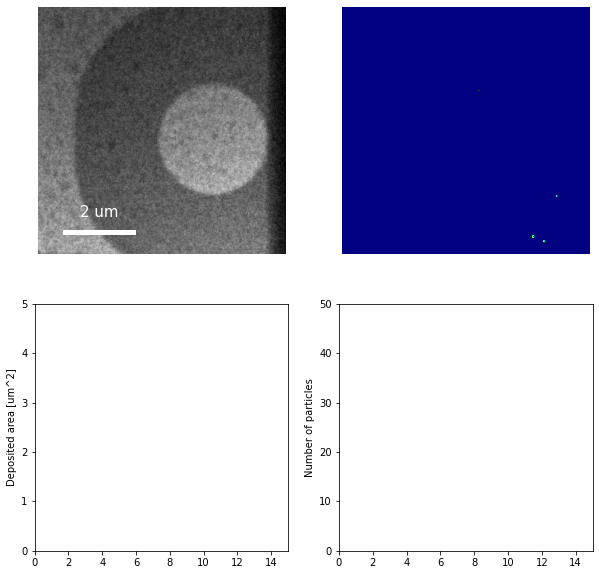

In [51]:
i=300
thres_cut=-30

ori_img=rotate_img(imgs['data'][i+75][350:950,600:1200], 4)
ref_img=gaussian(rotate_img(imgs['data'][74+150*int(i/150)][350:950,600:1200], 4), 3)

gaus_img=gaussian(ori_img,3)
gaus_subt_img=mask_img(gaus_img)-mask_img(ref_img)
threshold_img=gaus_subt_img<thres_cut
label_img = watershed_process(threshold_img)

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(221)
ax1.axis('off')
img_plot1=ax1.imshow(ori_img, cmap='gray')
scale_bar(ax1, ori_img, scale, 2)
#img_plot1=ax1.imshow(scale_bar(ori_img, scale), cmap='gray')

ax2 = fig.add_subplot(222)
ax2.axis('off')
img_plot2=ax2.imshow(label_img, cmap='gist_ncar')
#img_plot2=ax2.imshow(threshold_img, cmap='gray')

time=[]
count=[]
area=[]

ax3 = fig.add_subplot(223) # (rows, columns, 1st figure)
#ax1.set_title('Deposited area')
ax3.set_ylabel('Deposited area [um^2]')
ax3.set_xlim(0,15)
ax3.set_ylim(0,5)
graph3, = ax3.plot([], [], lw=2, c='gray')

ax4 = fig.add_subplot(224) # (rows, columns, 1st figure)
#ax1.set_title('Deposited area')
ax4.set_ylabel('Number of particles')
ax4.set_xlim(0,15)
ax4.set_ylim(0,50)
graph4, = ax4.plot([], [], lw=2, c='gray')

plt.show()

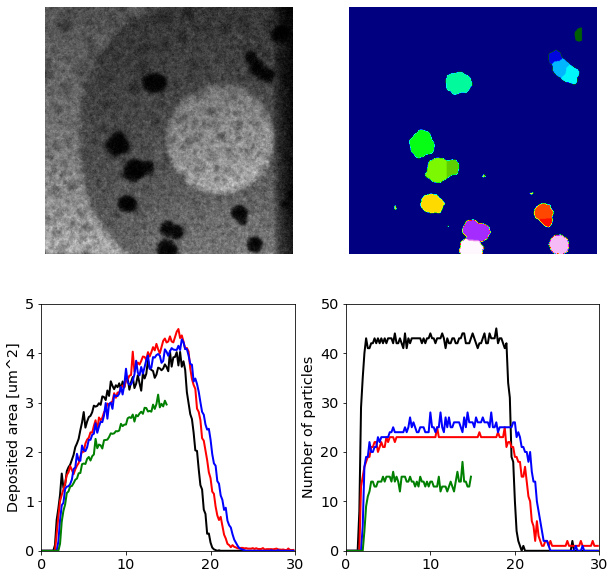

In [52]:
import matplotlib.pylab as pylab
params = {
        'legend.fontsize': 'x-large',
        'axes.labelsize': 'x-large',
        'axes.titlesize':'x-large',
        'xtick.labelsize':'x-large',
        'ytick.labelsize':'x-large',
        'axes.edgecolor':'black', 
        'xtick.color':'black',
        'ytick.color':'black', 
        'figure.facecolor':'white'
        }
pylab.rcParams.update(params)

thres_cut=-30

from matplotlib import animation as ani
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(221)
ax1.axis('off')
img_plot1=ax1.imshow(imgs['data'][0][350:950,600:1200], cmap='gray')

ax2 = fig.add_subplot(222)
ax2.axis('off')
img_plot2=ax2.imshow(imgs['data'][0][350:950,600:1200], cmap='gist_ncar')

time_p1=[]
area_p1=[]
count_p1=[]

time_p2=[]
area_p2=[]
count_p2=[]

time_p3=[]
area_p3=[]
count_p3=[]

time_p4=[]
area_p4=[]
count_p4=[]


ax3 = fig.add_subplot(223) # (rows, columns, 1st figure)
ax3.set_ylabel('Deposited area [um^2]')
ax3.set_xlim(0,30)
ax3.set_ylim(0,5)
plot_area_p1, =ax3.plot([], [], lw=2, c='black')
plot_area_p2, =ax3.plot([], [], lw=2, c='red')
plot_area_p3, =ax3.plot([], [], lw=2, c='blue')
plot_area_p4, =ax3.plot([], [], lw=2, c='green')

ax4 = fig.add_subplot(224) # (rows, columns, 1st figure)
ax4.set_ylabel('Number of particles')
ax4.set_xlim(0,30) 
ax4.set_ylim(0,50)
plot_count_p1, =ax4.plot([], [], lw=2, c='black')
plot_count_p2, =ax4.plot([], [], lw=2, c='red')
plot_count_p3, =ax4.plot([], [], lw=2, c='blue')
plot_count_p4, =ax4.plot([], [], lw=2, c='green')

def animate(i):
#for i in range(60):    

    ori_img=rotate_img(imgs['data'][i+75][350:950,600:1200], 4)
    ref_img=gaussian(rotate_img(imgs['data'][74+150*int(i/150)][350:950,600:1200], 4), 3)

    gaus_img=gaussian(ori_img,3)
    gaus_subt_img=mask_img(gaus_img)-mask_img(ref_img)
    threshold_img=gaus_subt_img<thres_cut
    label_img = watershed_process(threshold_img)

    img_plot1.set_data(ori_img)
    img_plot1.autoscale()
    img_plot2.set_data(label_img)
    img_plot2.autoscale()

    # Data extraction part
    cur_count=0
    cur_area=0
    
    cur_particles=regionprops(label_img, gaus_img)
    for particle in cur_particles:
        particle_area=(particle.area*(scale*10**6)**2) #[um2]
        if particle_area>0.01:
            cur_area=cur_area+particle_area
            cur_count=cur_count+1
    
    if i<150:
        time_p1.append(i/5)
        area_p1.append(cur_area)
        count_p1.append(cur_count)
        plot_area_p1.set_data(time_p1, area_p1)
        plot_count_p1.set_data(time_p1, count_p1)
        
    elif i<300:
        time_p2.append((i-150)/5)
        area_p2.append(cur_area)
        count_p2.append(cur_count)
        plot_area_p2.set_data(time_p2, area_p2)
        plot_count_p2.set_data(time_p2, count_p2)
        
    elif i<450:
        time_p3.append((i-300)/5)
        area_p3.append(cur_area)
        count_p3.append(cur_count)
        plot_area_p3.set_data(time_p3, area_p3)
        plot_count_p3.set_data(time_p3, count_p3)
        
    else:
        time_p4.append((i-450)/5)
        area_p4.append(cur_area)
        count_p4.append(cur_count)
        plot_area_p4.set_data(time_p4, area_p4)
        plot_count_p4.set_data(time_p4, count_p4)

movie=ani.FuncAnimation(fig, animate, 525, interval=50, repeat=False) #blit

movie.save('results\process_video.avi')
